# Reconstruction of the ball position from the trasformed points

IDEA:
- take the coordinates of the lower point of the ball (obtained applying the inverse of the homography to the transformed points)
- calculate the center of the ball from the radius

### Points acquisition

In [637]:
from pathlib import Path
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor, LinearRegression


In [ ]:
VIDEO_NUMBER = "7"
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_VIDEO_PATH = str(PROJECT_ROOT / "data" / f"recording_{VIDEO_NUMBER}" / f"Recording_{VIDEO_NUMBER}.mp4")
ORIGINAL_CSV_PATH = str(PROJECT_ROOT / "notebook" / "ball_detection" / "intermediate_data" / f"Circle_positions_cleaned_{VIDEO_NUMBER}.csv")
TRASFORMED_CSV_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "circle_positions" / f"Ball_lower_point_raw_{VIDEO_NUMBER}.csv")

OUTPUT_CSV_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "circle_positions" / f"Adjusted_positions_{VIDEO_NUMBER}.csv")
OUTPUT_VIDEO_PATH = str(PROJECT_ROOT / "data" / f"recording_{VIDEO_NUMBER}" / f"Ball_detected_processed_{VIDEO_NUMBER}.mp4")

Here I save the new file

In [639]:
def plot_radius(df):
    plt.figure(figsize=(8,6))
    plt.plot(df['frame'], df['radius'], 'o-', label='Radius')
    plt.xlabel('Frame')
    plt.ylabel('Radius')
    plt.title('Radius over frames')
    plt.legend()
    plt.show()

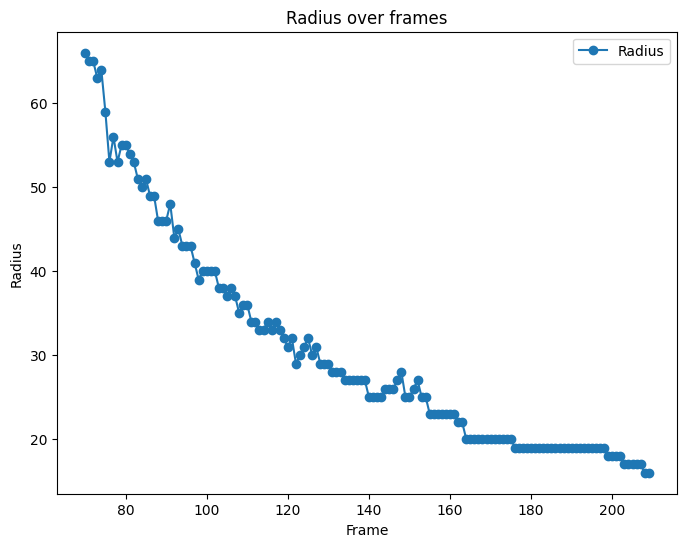

In [640]:
df_transformed = pd.read_csv(TRASFORMED_CSV_PATH)
df_original = pd.read_csv(ORIGINAL_CSV_PATH)

# Merge dataframes on 'frame'
df_merged = pd.merge(df_transformed, df_original[['frame', 'radius']], on='frame', how='left')

plot_radius(df_merged)

In [641]:
def decreasing_func(x, a, b, c):
    return a * np.exp(-b * x) + c  # Pure exponential decay function

In [642]:
def process_radius(df, median_window=25, quantile_baseline=0.05, ransac_threshold=0.5):
    # Ensure all frames are present
    all_frames = pd.DataFrame({'frame': np.arange(int(df['frame'].min()), int(df['frame'].max()) + 1)})
    df = pd.merge(all_frames, df, on='frame', how='left')

    # Smooth using rolling median
    df['median'] = df['radius'].rolling(window=median_window, center=True, min_periods=1).median()

    # Estimate baseline c using a low quantile
    c_est = df['radius'].quantile(quantile_baseline)

    # Prepare log-transformed target: log(radius - c)
    eps = 1e-6
    valid = df['radius'] > (c_est + eps)

    if valid.sum() < 10:
        raise ValueError("Too few valid points for robust fitting. Consider adjusting parameters.")

    x = df.loc[valid, 'frame'].values.reshape(-1, 1)
    y = np.log(df.loc[valid, 'radius'].values - c_est)

    # Robust regression in log-space
    ransac = RANSACRegressor(estimator=LinearRegression(), residual_threshold=ransac_threshold, max_trials=1000)
    ransac.fit(x, y)

    slope = -ransac.estimator_.coef_[0]
    intercept = ransac.estimator_.intercept_
    a_est = np.exp(intercept)

    # Predict over full frame range
    full_x = df['frame'].values
    fitted = decreasing_func(full_x, a_est, slope, c_est)
    df['radius'] = np.round(fitted).astype(int)

    return df

In [643]:
def plot_fit(df, smoothed_df):
    plt.figure(figsize=(8,6))
    plt.plot(df['frame'], df['radius'], 'o-', label='Original Radius', alpha=0.5)
    plt.plot(smoothed_df['frame'], smoothed_df['radius'], '-', label='Exponential Fit', linewidth=2)
    plt.xlabel('frame')
    plt.ylabel('Radius')
    plt.title('Radius over frames')
    plt.legend()
    plt.show()

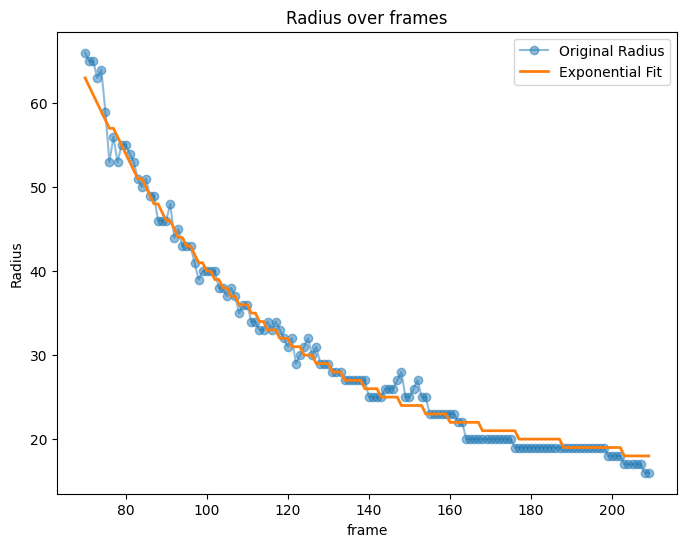

In [644]:
processed_df = process_radius(df_merged, median_window=5, quantile_baseline=0.001, ransac_threshold=0.1)
#processed_df = process_radius(df_merged, median_window=5, quantile_baseline=0.01, ransac_threshold=0.1)

plot_fit(df_merged, processed_df)

In [645]:
# Compute the new y coordinate
processed_df['y'] = processed_df.apply(
    lambda row: row['y'] - row['radius'] if pd.notna(row['y']) and pd.notna(row['radius']) else row['y'],
    axis=1
)

# Convert x, y, radius to integers if possible
for col in ['x', 'y', 'radius']:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce').dropna().astype(int)

# Keep only required columns
df_output = processed_df[['frame', 'x', 'y', 'radius']]

# Save to CSV
df_output.to_csv(OUTPUT_CSV_PATH, index=False)

print(f"Adjusted positions saved to: {OUTPUT_CSV_PATH}")

Adjusted positions saved to: /home/davic/projects/IACV_project/bowling-analysis/data/auxiliary_data/circle_positions/Adjusted_positions_7.csv


### Post-processing

In [646]:
df_adjusted = pd.read_csv(OUTPUT_CSV_PATH).set_index("frame")

# Open the input video
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Set up the video writer
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (width, height))

frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_number in df_adjusted.index:
        row = df_adjusted.loc[frame_number]
        x, y, radius = int(row["x"]), int(row["y"]), int(row["radius"])

        # Draw the circle on the frame
        cv2.circle(frame, (x, y), radius, color=(0, 255, 0), thickness=2)
        # Optional: draw a dot at the center
        cv2.circle(frame, (x, y), 5, color=(0, 0, 255), thickness=-1)

    out.write(frame)
    frame_number += 1

# Release resources
cap.release()
out.release()

print(f"Output video saved at: {OUTPUT_VIDEO_PATH}")

Output video saved at: /home/davic/projects/IACV_project/bowling-analysis/data/recording_7/Ball_detected_processed_7.mp4
